In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import yfinance as yf

In [3]:
# Get all of the stock files to process
files = os.listdir('data/')

# Initialize new dataframe to hold stock data
stocks = pd.DataFrame()

# For each stock to process
for x in range(len(files)):
    # Some tickers may be delisted, use try/except to avoid errors if ticker does not exist in yFinance
    try:
        # Assign current file name
        filename = files[x]

        # Read csv file for current ticker
        data = pd.read_csv('data/'+filename+'/stock_data_sentiment.csv')
        
        # Convert string time to datetime
        data['Datetime'] = pd.to_datetime(data['Datetime'])

        # Convert 0 sentiment to -1
        data.loc[data['Sentiment']==0, 'Sentiment'] = -1
        
        # Initialize Weights and Tweet numbers 
        data['Tweets'] = 1
        data['Weight'] = 1

        # Determine the mean and standard deviation of the number of followers a given user has for a given tweet
        # This ensures tweets with less tweets per day are treated equally 
        data['Followers_Mean'] = data['Followers'].rolling(10000, min_periods=1).mean()
        data['Followers_Std'] = data['Followers'].rolling(10000, min_periods=1).std()
        data['Followers_Std'] = data['Followers_Std'].fillna(data['Followers_Std'].values[1])

        # weight tweets from users with higher follower counts more heavily. Calculate based on mean and standard deviation gates
        data.loc[ (data['Followers']>=data['Followers_Mean']) & (data['Followers'] < (data['Followers_Mean']+data['Followers_Std'])), 'Weight'] += 1
        data.loc[ (data['Followers']>=(data['Followers_Mean']+data['Followers_Std'])) & (data['Followers'] < (data['Followers_Mean']+data['Followers_Std']*2)), 'Weight'] += 2
        data.loc[data['Followers']>=(data['Followers_Mean']+data['Followers_Std']*2), 'Weight'] += 3

        # Determine the mean and standard deviation of the number of re-tweets a given user has for a given tweet
        # This ensures tweets with less tweets per day are treated equally 
        data['RTs_Mean'] = data['RTs'].rolling(10000, min_periods=1).mean()
        data['RTs_Std'] = data['RTs'].rolling(10000, min_periods=1).std()
        data['RTs_Std'] = data['RTs_Std'].fillna(data['RTs_Std'].values[1])

        # Weight tweets with more re-tweests more heavily. Calculate based on mean and standard deviation gates
        data.loc[ (data['RTs']>=data['RTs_Mean']) & (data['RTs'] < (data['RTs_Mean']+data['RTs_Std'])), 'Weight'] += 1
        data.loc[ (data['RTs']>=(data['RTs_Mean']+data['RTs_Std'])) & (data['RTs'] < (data['RTs_Mean']+data['RTs_Std']*2)), 'Weight'] += 2
        data.loc[data['RTs']>=(data['RTs_Mean']+data['RTs_Std']*2), 'Weight'] += 3

        # multiply the sentiment score by the individual weigth
        data['Sentiment_Weighted'] = data['Sentiment']*data['Weight']

        # Group the stock data by months and days
        data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum(numeric_only=True)
        
        # Reassign the ticker name that was lost after grouping 
        data['Ticker'] = filename.split('_')[0]
        
        # Reassign date based on index values of month and day
        data['Date'] = pd.to_datetime([ str(x)+'/'+str(y)+'/2016' for (x,y) in data.index.values ])+datetime.timedelta(days=1)
        
        # Drop the index
        data = data.reset_index(drop=True)

        # Divide the sentiment by the total number of tweets 
        data['Sentiment_Weighted'] /= data['Tweets']
        
        # Get the rolling average of the sentiment and tweet volume
        data['Sentiment_MA'] = data['Sentiment_Weighted'].rolling(3, min_periods=1).mean()
        data['Tweets_MA'] = data['Tweets'].rolling(3, min_periods=1).mean()

        # Get the starting date and ending date to extract stock prices 
        start_date = data['Date'].min()
        end_date = data['Date'].max()+datetime.timedelta(days=2)

        # Download stock price data for given range of tweets 
        prices = yf.download(tickers=filename.split('_')[0], start=start_date, end=end_date).reset_index()
        
        # Calculate percent change based on stock price changes
        prices['Percent_Change'] = (prices['Adj Close'].pct_change()*100).shift(-1)
        
        # Bin percent changes by amount lost/gained by stock
        prices['Percent_Change_Bin'] = pd.cut(prices['Percent_Change'], [-100, 0, 2, 100], labels=[0, 1, 2])

        # Combine the stock sentiment data and the pricing data 
        data = data.merge(prices, on='Date', how='left')

        # Remove excess columns 
        data = data[['Ticker', 'Date', 'Sentiment_Weighted', 'Sentiment_MA', 'Tweets', 'Tweets_MA', 'Adj Close', 'Percent_Change', 'Percent_Change_Bin']]
        
        # Drop missing values for days without pricing information 
        data = data.dropna().reset_index(drop=True)
        
        # Save stock sentiment and pricing data to csv
        data.to_csv('data/' + filename + '/stock_data_inputs.csv', index=False)
        
        # Add ticker data to the main data set 
        stocks = pd.concat([stocks, data])
        
        # Print status of ticker 
        print(filename.split('_')[0], '- Completed')
    
    # If the ticker is not in yFinance 
    except Exception as e:
        # Print error message
        print(filename.split('_')[0], '-', e)
        

# Save data for all stocks to csv 
stocks.to_csv('combined_stock_inputs.csv', index=False)

[*********************100%%**********************]  1 of 1 completed


aal - Completed


[*********************100%%**********************]  1 of 1 completed


aapl - Completed


[*********************100%%**********************]  1 of 1 completed


adbe - Completed


[*********************100%%**********************]  1 of 1 completed


adp - Completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

adsk - Completed


akam - Completed


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['ALXN']: Exception('%ticker%: No timezone found, symbol may be delisted')


alxn - attempt to get argmax of an empty sequence


[*********************100%%**********************]  1 of 1 completed


amat - Completed


[*********************100%%**********************]  1 of 1 completed


amgn - Completed


[*********************100%%**********************]  1 of 1 completed


amzn - Completed


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['ATVI']: Exception('%ticker%: No timezone found, symbol may be delisted')


atvi - attempt to get argmax of an empty sequence


[*********************100%%**********************]  1 of 1 completed


avgo - Completed


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BBBY']: Exception('%ticker%: No timezone found, symbol may be delisted')


bbby - attempt to get argmax of an empty sequence


[*********************100%%**********************]  1 of 1 completed


bidu - Completed


[*********************100%%**********************]  1 of 1 completed


bmrn - Completed


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['CA']: Exception("%ticker%: Data doesn't exist for startDate = 1459137600, endDate = 1466136000")


ca - attempt to get argmax of an empty sequence


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['CELG']: Exception('%ticker%: No timezone found, symbol may be delisted')


celg - attempt to get argmax of an empty sequence


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['CERN']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed

cern - attempt to get argmax of an empty sequence


chkp - Completed


[*********************100%%**********************]  1 of 1 completed


chtr - Completed


[*********************100%%**********************]  1 of 1 completed


cmcsa - Completed


[*********************100%%**********************]  1 of 1 completed


cost - Completed


[*********************100%%**********************]  1 of 1 completed


csco - Completed


[*********************100%%**********************]  1 of 1 completed


csx - Completed


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['CTRP']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed

ctrp - attempt to get argmax of an empty sequence


ctsh - Completed


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['DISCA']: Exception('%ticker%: No timezone found, symbol may be delisted')


disca - attempt to get argmax of an empty sequence


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['DISCK']: Exception('%ticker%: No timezone found, symbol may be delisted')


disck - attempt to get argmax of an empty sequence


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['DISH']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed

dish - attempt to get argmax of an empty sequence



[*********************100%%**********************]  1 of 1 completed

dltr - Completed



[*********************100%%**********************]  1 of 1 completed

ea - Completed



[*********************100%%**********************]  1 of 1 completed

ebay - Completed




1 Failed download:
['ENDP']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")
[*********************100%%**********************]  1 of 1 completed

endp - attempt to get argmax of an empty sequence


esrx - Completed


[*********************100%%**********************]  1 of 1 completed


expe - Completed


[*********************100%%**********************]  1 of 1 completed


fast - Completed


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['FB']: Exception('%ticker%: No timezone found, symbol may be delisted')


fb - attempt to get argmax of an empty sequence


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['FISV']: Exception("%ticker%: Data doesn't exist for startDate = 1459137600, endDate = 1466222400")


fisv - attempt to get argmax of an empty sequence


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['FOX']: Exception("%ticker%: Data doesn't exist for startDate = 1459137600, endDate = 1466136000")


fox - attempt to get argmax of an empty sequence


(353, 4) (353,)
(1089, 4) (1089,)


0.2516069788797062




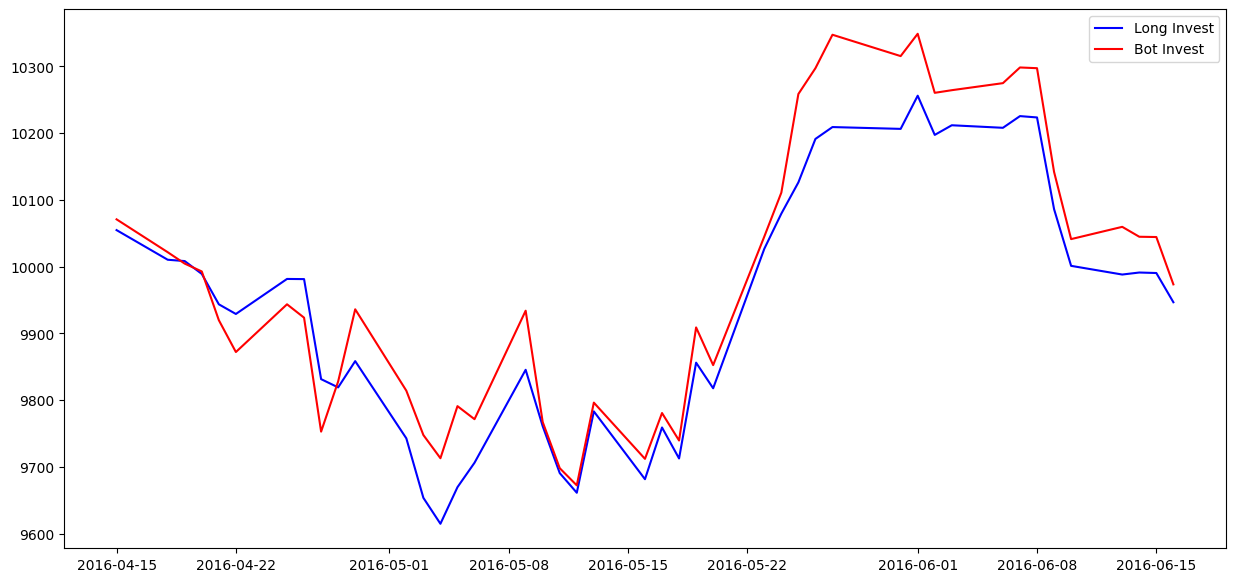

Long-Term Investment: 9946.58 ( -0.53 % )
Bot Trading: 9973.35 ( -0.27 % )


In [4]:
from sklearn.ensemble import RandomForestClassifier

# Sort values in stock sentiment/pricing data by date and ticker name 
stocks = stocks.sort_values(['Date', 'Ticker'])

# Use first 2 months of data as test data
d_train = stocks.loc[stocks['Date'] < datetime.datetime(year=2016, month=4, day=15)].reset_index(drop=True)

# Use last 2-3 months as test data 
d_test = stocks.loc[stocks['Date'] >= datetime.datetime(year=2016, month=4, day=15)].reset_index(drop=True)

# Remove extra columns from train data 
X_train = d_train[['Sentiment_Weighted', 'Sentiment_MA', 'Tweets', 'Tweets_MA']].values
y_train = d_train['Percent_Change_Bin'].values

# Remove extra solumns from test data 
X_test = d_test[['Sentiment_Weighted', 'Sentiment_MA', 'Tweets', 'Tweets_MA']].values
y_test = d_test['Percent_Change_Bin'].values

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print('\n')

# Define random forest classifier
model = RandomForestClassifier(random_state=1)

# Train model with training data
model.fit(X_train, y_train)

# Predict the test data 
preds = model.predict(X_test)

# Print the percent of predictions that resulted in investing in a losing stock
print(len(np.where( (preds>0) & (y_test==0) )[0])/len(preds))
print('\n')

# Add predictions to test dataset 
d_test['Prediction'] = preds

# Initialize starting capital to test model effectiveness
bot_capital = 10000
long_capital = 10000

# Add capital as first data points
bots = [bot_capital]
longs = [long_capital]

# Get unique dates
dates = d_test['Date'].sort_values().unique()

# For each date
for date in dates:
    # filter dataframe to date
    temp = d_test[d_test['Date']==date]
    
    # Calculate profit from investing equal parts to all tickers in timeframe
    long_capital = long_capital + ((long_capital/len(temp)) * (temp['Percent_Change']/100)).sum()
    
    # Calculate profit from using the Twitter bot to determine what stocks to invest in 
    temp = temp[temp['Prediction']>0]
    bot_capital = bot_capital + ((bot_capital/len(temp)) * (temp['Percent_Change']/100)).sum()
    
    # Keep track of the account totals ove time 
    longs.append(long_capital)
    bots.append(bot_capital)
    
    
# Plot the accounts balances over time
plt.figure(figsize=(15,7))
plt.plot(dates, longs[1:], c='b', label='Long Invest')
plt.plot(dates, bots[1:], c='r', label='Bot Invest')
plt.legend()
plt.show()

# Show the return from each account over time 
print('Long-Term Investment:', round(longs[-1],2), '(', round((longs[-1]-longs[0])/longs[0]*100,2), '% )')
print('Bot Trading:', round(bots[-1],2), '(', round((bots[-1]-bots[0])/bots[0]*100,2), '% )')